<h1><center> COMP551 Mini-Project 3: Classification of Image Data </center></h1>
<h3><center> Alireza Seyedkanani, Ehsan Estakhrianhaghighi, Mohammadali Rastak  </h3></center>
<h3><center> April 4, 2022 </h3></center>
<center> This code contains the implementation of a multilayer perceptron (MLP) from scratch and using convolutional neural network (CNN) using PyTorch. </</center>

# Preamble

We import the required packages.

In [ ]:
# importing the necessary packages
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import copy

# Task 1: Acquire and normalize the data

We use Keras datasets to import the **Fasion-MNIST** dataset.

In [ ]:
from keras.datasets import fashion_mnist
(train_imgs, train_labels), (test_imgs, test_labels) = fashion_mnist.load_data()

print('Train dataset size:', train_imgs.shape)
print('Test dataset size:', test_imgs.shape)

Train dataset size: (60000, 28, 28)
Test dataset size: (10000, 28, 28)


We can visualize the first few instances from the training dataset.

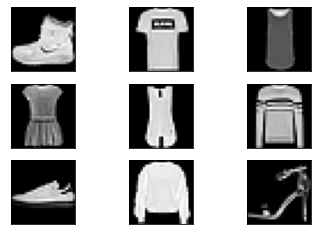

In [ ]:
for i in range(0,9):
  plt.subplot(330 + 1 +i)
  plt.imshow(train_imgs[i], cmap='gray')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
plt.show()

We have 10 classes that are eqaully distributed:

In [ ]:
print('Class labels: ', np.unique(test_labels))
print('Class distribution: ', np.bincount(train_labels))

Class labels:  [0 1 2 3 4 5 6 7 8 9]
Class distribution:  [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


First, we vectorize the training and test datasets:

In [ ]:
x_train_unscaled = train_imgs.reshape(train_imgs.shape[0],train_imgs.shape[1]*train_imgs.shape[2]).astype('float')
x_test_unscaled = test_imgs.reshape(test_imgs.shape[0],test_imgs.shape[1]*test_imgs.shape[2]).astype('float')

print('Train dataset vectorized size:', x_train_unscaled.shape)
print('Test dataset vectorized size:', x_test_unscaled.shape)

Train dataset vectorized size: (60000, 784)
Test dataset vectorized size: (10000, 784)


And then, we normalize the data. We use zero mean to zero center the data and then scale each dimension by its standard deviation to have a unit variance. In order to do so, we employ StandardScaler from sklear preprocessing. Furthermore, we employ one-hot encoder from sklearn preprocessing to perform one-hot encoding on the targets since we need to do multi-class classification using softmax.

In [ ]:
scaler = StandardScaler().fit(x_train_unscaled)
x_train = scaler.transform(x_train_unscaled)
x_test = scaler.transform(x_test_unscaled)

onehot_encoder = OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(train_labels[:,None])
y_test = onehot_encoder.fit_transform(test_labels[:,None])

# Task 2: Implement a Multilayer Perceptron

Here, we implement an MLP from scracth. We first define various activation functions along with their derivatives. The activation for the output layer is softmax. For the softmax activation function, in order to avoid overflow in exponentials and keep it stabilized, we subtract the maximum value of the input from the exponents. Our MLP class forms the network architecture by taking the size of hidden layers as a list (*hidden_size*) and as they appear in the forward path. For dropout regularization, it takes the probabilities of the active nodes in each layer **including the input layer** as a list (*dropout*).

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))
logistic_d = lambda z: logistic(z)*(1-logistic(z))

ReLu = lambda z: np.maximum(0, z)
ReLu_d = lambda z: np.heaviside(z, 0)

lReLu = lambda z: np.maximum(0, z) + 0.01*np.minimum(0, z)
lReLu_d = lambda z: np.heaviside(z, 0)-0.01*np.heaviside(-z,1)

tanh = lambda z: (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))
tanh_d = lambda z: 1-(tanh(z))**2

softmax = lambda z: np.exp(z - np.max(z,axis=1)[:,None])/np.sum(np.exp(z - np.max(z,axis=1)[:,None]),1)[:,None]

class MLP:

  def __init__(self, activation_fn=ReLu, hidden_size=[64,64], dropout=[1,1,1]):
    self.hidden_size = hidden_size
    self.num_layers = len(hidden_size) + 2
    self.activation_fn = activation_fn
    self.dropout = dropout
    if activation_fn==ReLu:
      self.activation_fnd = ReLu_d
    elif activation_fn==lReLu:
      self.activation_fnd = lReLu_d
    elif activation_fn==tanh:
      self.activation_fnd = tanh_d
    elif activation_fn==logistic:
      self.activation_fnd = logistic_d

  def restore_weights(self, params):
    self.params = params
    return self

  def fit(self, x, y, optimizer):
    def gradient(x, y, params):
      N, D = x.shape
      weights, biases = params
      db = [np.zeros(b.shape) for b in biases]
      dw = [np.zeros(w.shape) for w in weights]
      # forward path
      activation = x
      d = np.random.rand(activation.shape[0], activation.shape[1]) < self.dropout[0]
      activation = np.multiply(activation, d)/self.dropout[0]
      activations = [activation]; zs=[]
      for b, w, d in zip(biases[:-1], weights[:-1], self.dropout[1:]):
        z = np.dot(activation, w) + b
        zs.append(z)
        activation = self.activation_fn(z)
        activation = np.multiply(activation, np.random.rand(activation.shape[0], activation.shape[1]) < d)/d
        activations.append(activation)
      z = np.dot(activation, weights[-1]) + biases[-1]
      zs.append(z)
      activation = softmax(z)
      activations.append(activation)
      # Backward path
      delta = activations[-1] - y
      dw[-1] = np.dot(activations[-2].T, delta)/N
      db[-1] = np.dot(np.ones([activations[-2].shape[0], 1]).T, delta)/N
      for l in range(2, self.num_layers):
        delta = np.dot(delta, weights[-l+1].T) * self.activation_fnd(zs[-l])
        dw[-l] = np.dot(activations[-l-1].T, delta)/N
        db[-l] = np.dot(np.ones([activations[-l-1].shape[0], 1]).T, delta)/N
      dparams = [dw, db]
      return dparams

    # initialization
    N, D = x.shape
    C = y.shape[1]
    size = self.hidden_size
    size.append(C)
    size.insert(0,D)
    self.size = size
    biases0 = [np.random.randn(1, i) * 0.01 for i in size[1:]]
    # we assume xw+b
    if self.activation_fn == ReLu:
      weights0 = [np.random.randn(i, j) * np.sqrt(2/i) for i, j in zip(size[:-1], size[1:])]
    else:
      weights0 = [np.random.randn(i, j) * np.sqrt(1/i) for i, j in zip(size[:-1], size[1:])]
    params0 = [weights0, biases0]
    self.params0 = params0
    self.params = optimizer.run(gradient, x, y, params0, self.activation_fn)
    return self

  def predict(self, x):
    # for an input a it calculates the output.
    weights, biases = self.params
    for b, w in zip(biases[:-1], weights[:-1]):
      x = self.activation_fn(np.dot(x, w) + b)
    yh = softmax(np.dot(x, weights[-1]) + biases[-1])
    return yh

We also implement mini-batch stochstic gradient descent as our optimization algorithm. If the mini-batch size is equal to the size of the train dataset, then the algorithm will be transofrmed to batch gradient descent. We also include the record history (*record_history*) option to save the losses and accuracies for the training in any desired intervals (*history_interval*). For example, if the recording interval is set to 10, the loss and accuracies are going to ba calculated and saved every 10 epochs. In the case of providing a test dataset in the form of a tuple (x_test, y_test), the corresponding accuracy and loss are going to be calculated and stored for the testing as well.

In [ ]:
def logsumexp(z):
  zmax = np.max(z,axis=1)[:,None]
  log_sum_exp = zmax + np.log(np.sum(np.exp(z - zmax), axis=1))[:,None]
  return log_sum_exp

class minibatchSGD:

  def __init__(self, learning_rate=.001, mini_batch_size=8, max_epochs=1e3, epsilon=1e-8,
               history_record=True, history_interval=1,
               test_data=None):
    self.learning_rate = learning_rate
    self.max_epochs = max_epochs
    self.epsilon = epsilon
    self.mini_batch_size = mini_batch_size
    self.history_record = history_record
    self.history_interval = history_interval
    self.test_data = test_data

  def run(self, gradient_fn, x, y, params, activation_fn):
    norms = np.array([np.inf])
    hist_train_error = []
    hist_train_loss = []
    hist_test_error = []
    hist_test_loss = []
    best_test_error = 1
    best_test_loss = np.inf
    best_epoch = []
    best_params = []
    epoch = 1
    while np.any(norms > self.epsilon) and epoch <= self.max_epochs:
      N = x.shape[0]
      # we shuffle the data in each epoch
      inds = np.random.permutation(N)
      x_shuffled = x[inds]
      y_shuffled = y[inds]
      mini_batches_x = [x_shuffled[k:k+self.mini_batch_size] for k in range(0, N, self.mini_batch_size)]
      mini_batches_y = [y_shuffled[k:k+self.mini_batch_size] for k in range(0, N, self.mini_batch_size)]
      for x_mini, y_mini in zip(mini_batches_x, mini_batches_y):
        grad = gradient_fn(x_mini, y_mini, params)
        for p in range(len(params[0])):
          params[0][p] -= self.learning_rate * grad[0][p]
          params[1][p] -= self.learning_rate * grad[1][p]
      norms0 = np.array([np.linalg.norm(g) for g in grad[0]])
      norms1 = np.array([np.linalg.norm(g) for g in grad[1]])
      norms = np.append(norms0, norms1)
      if self.history_record and (epoch==1 or epoch%self.history_interval == 0):
        weights, biases = params
        activation = x
        for b, w in zip(biases[:-1], weights[:-1]):
          activation = activation_fn(np.dot(activation, w) + b)
        u = np.dot(activation, weights[-1]) + biases[-1]
        train_loss = -np.mean(np.sum(u*y, axis=1)[:,None] - logsumexp(u))
        y_pred = np.argmax(softmax(np.dot(activation, weights[-1]) + biases[-1]), axis=1)
        y_train = np.argmax(y, axis=1)
        train_error = np.mean(y_train != y_pred)
        if self.test_data:
          activation_test = self.test_data[0]
          for b, w in zip(biases[:-1], weights[:-1]):
            activation_test = activation_fn(np.dot(activation_test, w) + b)
          u = np.dot(activation_test, weights[-1]) + biases[-1]
          test_loss = -np.mean(np.sum(u*self.test_data[1], axis=1)[:,None] - logsumexp(u))
          y_pred = np.argmax(softmax(np.dot(activation_test, weights[-1]) + biases[-1]), axis=1)
          y_test = np.argmax(self.test_data[1], axis=1)
          test_error = np.mean(y_test != y_pred)
          if test_loss < best_test_loss:
            best_params = copy.deepcopy(params)
            best_test_error = test_error
            best_test_loss = test_loss
            best_epoch = epoch
          hist_test_error.append((epoch, test_error))
          hist_test_loss.append((epoch, test_loss))
        hist_train_error.append((epoch, train_error))
        hist_train_loss.append((epoch, train_loss))
      epoch += 1
    self.hist_train_error = hist_train_error
    self.hist_train_loss = hist_train_loss
    self.hist_test_error = hist_test_error
    self.hist_test_loss = hist_test_loss
    self.best_test_error = best_test_error
    self.best_test_loss = best_test_loss
    self.best_params = best_params
    self.best_epoch = best_epoch
    return params

  def history(self, report=False, plot=True, output=False, save_plot=False):
    if self.history_record and report:
      for epoch, train_error in self.hist_train_error:
        print('Iteration: ', epoch, 'Train Error:', train_error)

    if self.history_record and plot:
      epoch, train_loss = zip(*self.hist_train_loss)
      plt.plot(epoch, train_loss, label='Train Loss')
      plt.title('Loss vs epochs')
      if self.test_data:
        epoch, test_loss = zip(*self.hist_test_loss)
        plt.plot(epoch, test_loss, label='Test Loss')
        plt.axvline(x=self.best_epoch, color='red')
        plt.title('Loss vs epochs (acc. with best model = %1.3f)' % (1 - self.best_test_error))
      plt.legend(loc='upper right')
      plt.xlabel('Epochs')
      plt.ylabel('Loss (cross-entropy)')
      if save_plot:
        plt.savefig('optimizer_plot.pdf', format='pdf', bbox_inches='tight')
        files.download('optimizer_plot.pdf')
      plt.show()

    if not self.history_record:
      print('No history record!')
    if output:
      return (self.hist_train_error, self.hist_test_error, self.hist_train_loss, self.hist_test_loss,
              self.best_test_error, self.best_test_loss, self.best_epoch, self.best_params)

In [ ]:
def evaluate_acc(y, yh):
  accuracy = np.mean(yh == y)
  return accuracy

# Task 3: Run the experiments and report

## Task 3.1: Models with different network depth

We define our models as follows:

**Model 1**: with no hidden layers (`[]`)

**Model 2**: with one hoiden layer having 128 units (`[128]`)

**Model 3**: with two hidden layers each having 128 units (`[128,128]`)

All these models are with ReLu activations in the hidden layers and without any dropouts.

We start with model 3. We do some experiments with different learning rates and different mini-batch sizes to find the best hyper parameters to train this model.

In [ ]:
N= x_train.shape[0]

learning_rate = [0.01, 0.001]
batch_size = [16, 64, 256]
acc = []

for lr in learning_rate:
  for bs in batch_size:
    model3 = MLP(activation_fn=ReLu,
             hidden_size=[128,128],
             dropout=[1,1,1])

    optimizer = minibatchSGD(learning_rate=lr,
                             mini_batch_size=bs,
                             max_epochs=500,
                             history_record=True,
                             history_interval=1,
                             test_data=(x_test,y_test))

    model3.fit(x_train, y_train, optimizer)
    record3 = optimizer.history(plot=False, output=True)
    acc.append(1 - record3[-4])
    print('(learning rate = %1.3f, batch size = %d, best epoch = %d) : test accuracy score with the best model = %1.3f ' %(lr, bs, record3[-2], acc[-1]))

(learning rate = 0.010, batch size = 16, best epoch = 9) : test accuracy score with the best model = 0.885 
(learning rate = 0.010, batch size = 64, best epoch = 18) : test accuracy score with the best model = 0.879 
(learning rate = 0.010, batch size = 256, best epoch = 66) : test accuracy score with the best model = 0.882 
(learning rate = 0.001, batch size = 16, best epoch = 45) : test accuracy score with the best model = 0.880 
(learning rate = 0.001, batch size = 64, best epoch = 171) : test accuracy score with the best model = 0.881 
(learning rate = 0.001, batch size = 256, best epoch = 500) : test accuracy score with the best model = 0.878 


The trained models have almost similar accuracies; however, it seems increasing the batch size slows down the convergence rate. It is also the case for decreasing the learning rate. For instance, with a batch size of 16 and a learning rate of 0.01, after the 9th epoch, the test loss would increase. In other words, the best model with the lowest test loss is obtained at the 9th epoch. Increasing the batch size to 64 and 256, the model with the lowest test loss is obtained at 18th and 66th epochs, respectively. In order to have a fast convergence, we can select a batch size of 16 and a learning rate of 0.01. Furthermore, maximum epochs can be set to 50 to make sure that the algorithm sees the lowest test error so that we can select the best model. It is also worth mentioning that increasing the batch size enhances the stability of the training process. So we also check for it by comparing the convergence curves of models with batch sizes of 16, 64, and 256 with appropriate maximum epochs. Learning rate of 0.001 seems a bit slow. For example, for the batch size of 256, a learning rate of 0.001 leads to a slow convergence such that the minimum test loss occurs beyond maximum epochs of 500.

In [ ]:
model3 = MLP(activation_fn=ReLu,
             hidden_size=[128,128],
             dropout=[1,1,1])

optimizer = minibatchSGD(learning_rate=0.01,
                         mini_batch_size=16,
                         max_epochs=50,
                         history_record=True,
                         history_interval=1,
                         test_data=(x_test,y_test))

y_prob = model3.fit(x_train, y_train, optimizer).predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score at the end of the run: ', evaluate_acc(y, y_pred))

Test accuracy score at the end of the run:  0.8825


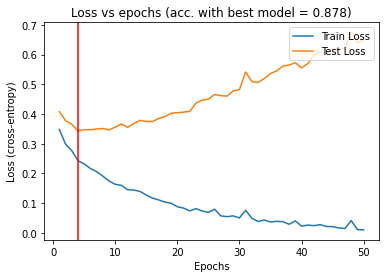

Test accuracy score of the model with the lowest test loss:  0.8778


In [ ]:
record = optimizer.history(plot=True, output=True)

y_prob = model3.restore_weights(record[-1]).predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score of the model with the lowest test loss: ', evaluate_acc(y, y_pred))

Let's try the batch size of 64 and use maximum epochs of 100. It seems smoother and more stable.

In [ ]:
model3 = MLP(activation_fn=ReLu,
             hidden_size=[128,128],
             dropout=[1,1,1])

optimizer = minibatchSGD(learning_rate=0.01,
                         mini_batch_size=64,
                         max_epochs=100,
                         history_record=True,
                         history_interval=1,
                         test_data=(x_test,y_test))

y_prob = model3.fit(x_train, y_train, optimizer).predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score at the end of the run: ', evaluate_acc(y, y_pred))

Test accuracy score at the end of the run:  0.8836


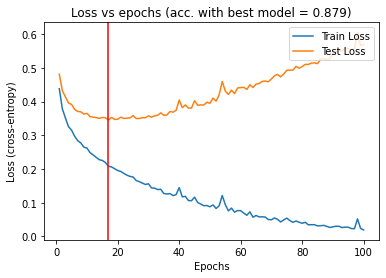

Test accuracy score of the model with the lowest test loss:  0.8785


In [ ]:
record = optimizer.history(plot=True, output=True)

y_prob = model3.restore_weights(record[-1]).predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score of the model with the lowest test loss: ', evaluate_acc(y, y_pred))

Let's try the batch size of 256 and use maximum epochs of 500. The convergence curve seems smoother and more stable.

In [ ]:
N= x_train.shape[0]
model3 = MLP(activation_fn=ReLu,
             hidden_size=[128,128],
             dropout=[1,1,1])

optimizer = minibatchSGD(learning_rate=.01,
                         mini_batch_size=256,
                         max_epochs=500,
                         history_record=True,
                         history_interval=1,
                         test_data=(x_test,y_test))

y_prob = model3.fit(x_train, y_train, optimizer).predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score at the end of the run: ', evaluate_acc(y, y_pred))

Test accuracy score at the end of the run:  0.8751


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

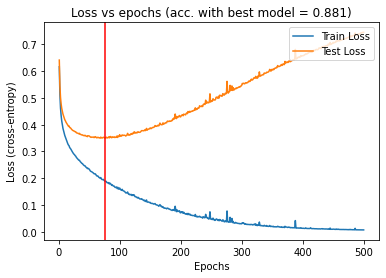

Test accuracy score of model 3 with the best parameters:  0.8808


In [ ]:
record = optimizer.history(plot=True, output=True, save_plot=False)

# the parameters of the model with the lowest test loss are stored in record.
# we read these parameters and update the model.
y_prob = model3.restore_weights(record[-1]).predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score of model 3 with the best parameters: ', evaluate_acc(y, y_pred))

We can carry out a similar study on the model with one hidden layer of size 128, i.e. model 2.

In [ ]:
N= x_train.shape[0]

learning_rate = [0.01, 0.001]
batch_size = [16, 64, 256]
acc = []

for lr in learning_rate:
  for bs in batch_size:
    model2 = MLP(activation_fn=ReLu,
             hidden_size=[128],
             dropout=[1,1])

    optimizer = minibatchSGD(learning_rate=lr,
                             mini_batch_size=bs,
                             max_epochs=500,
                             history_record=True,
                             history_interval=1,
                             test_data=(x_test,y_test))

    model2.fit(x_train, y_train, optimizer)
    record2 = optimizer.history(plot=False, output=True)
    acc.append(1 - record2[-4])
    print('(learning rate = %1.3f, batch size = %d, best epoch = %d) : test accuracy score with the best model = %1.3f ' %(lr, bs, record2[-2], acc[-1]))

(learning rate = 0.010, batch size = 16, best epoch = 12) : test accuracy score with the best model = 0.885 
(learning rate = 0.010, batch size = 64, best epoch = 31) : test accuracy score with the best model = 0.881 
(learning rate = 0.010, batch size = 256, best epoch = 110) : test accuracy score with the best model = 0.880 
(learning rate = 0.001, batch size = 16, best epoch = 83) : test accuracy score with the best model = 0.884 
(learning rate = 0.001, batch size = 64, best epoch = 293) : test accuracy score with the best model = 0.882 
(learning rate = 0.001, batch size = 256, best epoch = 500) : test accuracy score with the best model = 0.873 


Again, the accuracies are almost similar. We plot the learning curve for model 2 with a batch size of 256 and a learning rate of 0.01 and maximum epochs of 500. For a faster but more unstable convergence we can choose a smaller batch size.

In [ ]:
N= x_train.shape[0]
model2 = MLP(activation_fn=ReLu,
             hidden_size=[128],
             dropout=[1,1])

optimizer = minibatchSGD(learning_rate=.01,
                         mini_batch_size=256,
                         max_epochs=500,
                         history_record=True,
                         history_interval=1,
                         test_data=(x_test,y_test))

y_prob = model2.fit(x_train, y_train, optimizer).predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score at the end of the run: ', evaluate_acc(y, y_pred))

Test accuracy score at the end of the run:  0.8832


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

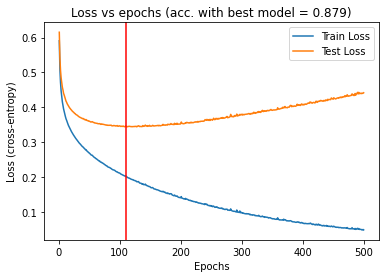

Test accuracy score of model 2 with the best parameters:  0.8791


In [ ]:
record = optimizer.history(plot=True, output=True, save_plot=False)

# the parameters of the model with the lowest test loss are stored in record.
# we read these parameters and update the model.
y_prob = model2.restore_weights(record[-1]).predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score of model 2 with the best parameters: ', evaluate_acc(y, y_pred))

Similarly, we carry out a parametr study on the model 1 with no hidden layers.

In [ ]:
N= x_train.shape[0]

learning_rate = [0.01, 0.001]
batch_size = [16, 64, 256]
acc = []

for lr in learning_rate:
  for bs in batch_size:
    model1 = MLP(activation_fn=ReLu,
             hidden_size=[],
             dropout=[1])

    optimizer = minibatchSGD(learning_rate=lr,
                             mini_batch_size=bs,
                             max_epochs=500,
                             history_record=True,
                             history_interval=1,
                             test_data=(x_test,y_test))

    model1.fit(x_train, y_train, optimizer)
    record1 = optimizer.history(plot=False, output=True)
    acc.append(1 - record1[-4])
    print('(learning rate = %1.3f, batch size = %d, best epoch = %d) : test accuracy score with the best model = %1.3f ' %(lr, bs, record1[-2], acc[-1]))

(learning rate = 0.010, batch size = 16, best epoch = 8) : test accuracy score with the best model = 0.841 
(learning rate = 0.010, batch size = 64, best epoch = 35) : test accuracy score with the best model = 0.844 
(learning rate = 0.010, batch size = 256, best epoch = 136) : test accuracy score with the best model = 0.844 
(learning rate = 0.001, batch size = 16, best epoch = 72) : test accuracy score with the best model = 0.844 
(learning rate = 0.001, batch size = 64, best epoch = 256) : test accuracy score with the best model = 0.844 
(learning rate = 0.001, batch size = 256, best epoch = 499) : test accuracy score with the best model = 0.842 


The accuracies are almost the same and only the convergence rate is different. We plot the learning curve for model 1 with a learning rate of 0.01 and a batch size of 256 with a maximum epochs of 500.

In [ ]:
N= x_train.shape[0]
model1 = MLP(activation_fn=ReLu,
             hidden_size=[],
             dropout=[1])

optimizer = minibatchSGD(learning_rate=.01,
                         mini_batch_size=256,
                         max_epochs=500,
                         history_record=True,
                         history_interval=1,
                         test_data=(x_test,y_test))

y_prob = model1.fit(x_train, y_train, optimizer).predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score at the end of the run: ', evaluate_acc(y, y_pred))

Test accuracy score at the end of the run:  0.8443


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

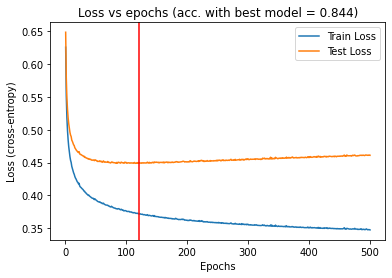

Test accuracy score of model 1 with the best parameters:  0.8439


In [ ]:
record = optimizer.history(plot=True, output=True, save_plot=False)

# the parameters of the model with the lowest test loss are stored in record.
# we read these parameters and update the model.
y_prob = model1.restore_weights(record[-1]).predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score of model 1 with the best parameters: ', evaluate_acc(y, y_pred))

We can check with sklearn MLP classifier to see if our obtained accuracies are correct or not. It seems our model's preformance is acceptable.

In [ ]:
# To check with the available MLP classifiers
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(128,128),
                    learning_rate_init=0.01,
                    max_iter=10000,
                    solver='sgd')

y_pred = clf.fit(x_train, y_train).predict(x_test)

yh = np.argmax(y_pred, axis=1)
y = np.argmax(y_test, axis=1)

print(evaluate_acc(y, yh))

0.878


## Task 3.2: Models with different activation functions

We now take model 3 (with two hidden layers of size 128) but this time we use different activation functions. For faster convergence, we use a learnign rate of 0.01 with a batch size of 64 and maximum epochs of 100.

In [ ]:
activation_function = [ReLu, lReLu, tanh, logistic]
activation_function_names = ['ReLu', 'lReLu', 'tanh', 'logistic']
acc = []

for af, afn in zip(activation_function, activation_function_names):
  model3 = MLP(activation_fn=af,
               hidden_size=[128,128],
               dropout=[1,1,1])

  optimizer = minibatchSGD(learning_rate=0.01,
                           mini_batch_size=64,
                           max_epochs=100,
                           history_record=True,
                           history_interval=1,
                           test_data=(x_test,y_test))

  model3.fit(x_train, y_train, optimizer)
  record3 = optimizer.history(plot=False, output=True)
  acc.append(1 - record3[-4])
  print('(activation function = %s, best epoch = %d) : test accuracy score with the best model = %1.3f ' %(afn, record3[-2], acc[-1]))

(activation function = ReLu, best epoch = 21) : test accuracy score with the best model = 0.879 
(activation function = lReLu, best epoch = 21) : test accuracy score with the best model = 0.883 
(activation function = tanh, best epoch = 27) : test accuracy score with the best model = 0.881 
(activation function = logistic, best epoch = 100) : test accuracy score with the best model = 0.877 


It seems leaky ReLu results in a similar performnace as ReLu since the epoch at after which overfitting occurs is the same for both (epoch 21). With tanh, the convergence is a bit slower and the lowest test loss occurs at epoch 27. It might be due to gradient vanishing with tanh activation function. We have also tested logistic function as the activation function which led to slower convergence compared to other activations (the lowest test loss did not occur in the first 100 epochs). It is due to gradient vanishing issues with logistic function. Therefore, maximum number of epochs shall be increased. Below we plot the learning curves for models with lReLu, tanh, and logistic activations.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

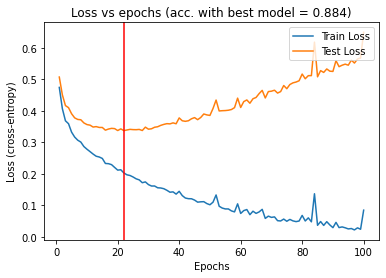

In [ ]:
model3 = MLP(activation_fn=lReLu,
             hidden_size=[128,128],
             dropout=[1,1,1])

optimizer = minibatchSGD(learning_rate=0.01,
                         mini_batch_size=64,
                         max_epochs=100,
                         history_record=True,
                         history_interval=1,
                         test_data=(x_test,y_test))

model3.fit(x_train, y_train, optimizer).predict(x_test)
optimizer.history(plot=True, output=False, save_plot=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

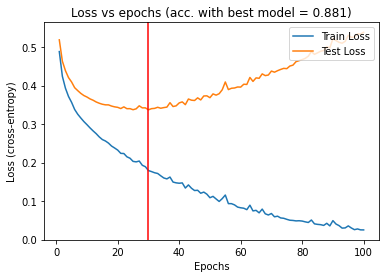

In [ ]:
model3 = MLP(activation_fn=tanh,
             hidden_size=[128,128],
             dropout=[1,1,1])

optimizer = minibatchSGD(learning_rate=0.01,
                         mini_batch_size=64,
                         max_epochs=100,
                         history_record=True,
                         history_interval=1,
                         test_data=(x_test,y_test))

model3.fit(x_train, y_train, optimizer).predict(x_test)
optimizer.history(plot=True, output=False, save_plot=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

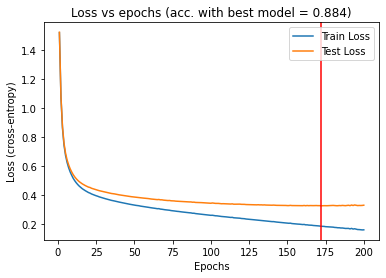

In [ ]:
model3 = MLP(activation_fn=logistic,
             hidden_size=[128,128],
             dropout=[1,1,1])

optimizer = minibatchSGD(learning_rate=0.01,
                         mini_batch_size=64,
                         max_epochs=200,
                         history_record=True,
                         history_interval=1,
                         test_data=(x_test,y_test))

model3.fit(x_train, y_train, optimizer).predict(x_test)
optimizer.history(plot=True, output=False, save_plot=False)

## Task 3.3: Models with dropout regularization

We now carry out some experiments on model 3 (two hidden layers of 128 units with ReLu activation) with dropout regularization. Usually, we do not use large dropout in the first layer since by doing this we remove some features from the training process. However, we try different amounts of dropout in the first and second hidden layers.

In [ ]:
first_layer_droput = [1, 0.9]
other_layers_dropout = [1, 0.9, 0.75, 0.5]
acc = []

for d1 in first_layer_droput:
  for d2 in other_layers_dropout:
    model3 = MLP(activation_fn=ReLu,
             hidden_size=[128,128],
             dropout=[d1,d2,d2])

    optimizer = minibatchSGD(learning_rate=0.01,
                             mini_batch_size=64,
                             max_epochs=100,
                             history_record=True,
                             history_interval=1,
                             test_data=(x_test,y_test))

    model3.fit(x_train, y_train, optimizer)
    record3 = optimizer.history(plot=False, output=True)
    acc.append(1 - record3[-4])
    print('(dropout = [%g, %g, %g], best epoch = %d) : test accuracy score with the best model = %1.3f ' %(d1, d2, d2, record3[-2], acc[-1]))

(dropout = [1, 1, 1], best epoch = 20) : test accuracy score with the best model = 0.882 
(dropout = [1, 0.9, 0.9], best epoch = 96) : test accuracy score with the best model = 0.894 
(dropout = [1, 0.75, 0.75], best epoch = 95) : test accuracy score with the best model = 0.872 
(dropout = [1, 0.5, 0.5], best epoch = 84) : test accuracy score with the best model = 0.823 
(dropout = [0.9, 1, 1], best epoch = 41) : test accuracy score with the best model = 0.887 
(dropout = [0.9, 0.9, 0.9], best epoch = 92) : test accuracy score with the best model = 0.889 
(dropout = [0.9, 0.75, 0.75], best epoch = 78) : test accuracy score with the best model = 0.870 
(dropout = [0.9, 0.5, 0.5], best epoch = 83) : test accuracy score with the best model = 0.823 


It seems adding a small amount of dropout to hidden layers can enhance the accuracy of the model. We check this for model 3 with dropout of 0.9 in the hidden layers.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

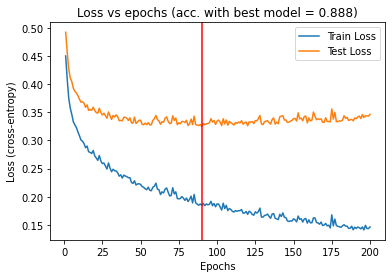

In [ ]:
model3 = MLP(activation_fn=ReLu,
             hidden_size=[128,128],
             dropout=[1,0.9,0.9])

optimizer = minibatchSGD(learning_rate=0.01,
                         mini_batch_size=64,
                         max_epochs=200,
                         history_record=True,
                         history_interval=1,
                         test_data=(x_test,y_test))

model3.fit(x_train, y_train, optimizer).predict(x_test)
optimizer.history(plot=True, output=False, save_plot=True)

## Task 3.4: Model with unnormalized data

We now use model 3 with two hidden layers of size 128 and ReLu activations and train it using unnormalized data to see how it affects the accuracy and convergence of the model. We use a learning rate of 0.01 with a batch size of 64 and maximum epochs of 100.

In [ ]:
model3 = MLP(activation_fn=ReLu,
             hidden_size=[128,128],
             dropout=[1,1,1])

optimizer = minibatchSGD(learning_rate=0.01,
                         mini_batch_size=64,
                         max_epochs=100,
                         history_record=True,
                         history_interval=1,
                         test_data=(x_test_unscaled, y_test))

y_prob = model3.fit(x_train_unscaled, y_train, optimizer).predict(x_test_unscaled)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score at the end of the run: ', evaluate_acc(y, y_pred))

Test accuracy score at the end of the run:  0.1


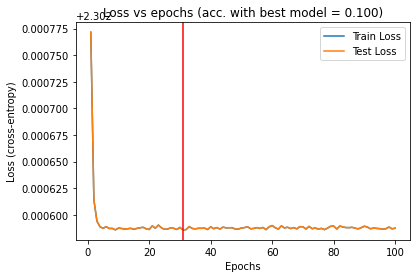

Test accuracy score of the model with the lowest test loss:  0.1


In [ ]:
record = optimizer.history(plot=True, output=True)

y_prob = model3.restore_weights(record[-1]).predict(x_test_unscaled)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score of the model with the lowest test loss: ', evaluate_acc(y, y_pred))

With unnormalized data and with the current learning rate and weight initialization, no convergence is obtained. We tried by changing the magnitude of initialized weights or changing the learning rate but it was not successful.

In [ ]:
model3 = MLP(activation_fn=ReLu,
             hidden_size=[128,128],
             dropout=[1,1,1])

optimizer = minibatchSGD(learning_rate=1,
                         mini_batch_size=64,
                         max_epochs=100,
                         history_record=True,
                         history_interval=1,
                         test_data=(x_test_unscaled, y_test))

y_prob = model3.fit(x_train_unscaled, y_train, optimizer).predict(x_test_unscaled)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score at the end of the run: ', evaluate_acc(y, y_pred))

Test accuracy score at the end of the run:  0.1


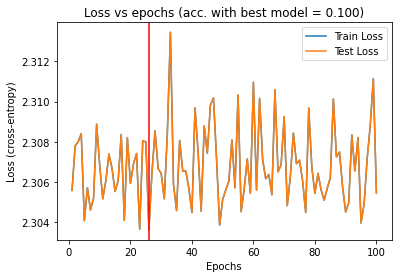

Test accuracy score of the model with the lowest test loss:  0.1


In [ ]:
record = optimizer.history(plot=True, output=True)

y_prob = model3.restore_weights(record[-1]).predict(x_test_unscaled)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score of the model with the lowest test loss: ', evaluate_acc(y, y_pred))

With unnormalized images, we believe there are overflows happening in the algorithm. That is why the model does not converge and produces a identical outputs. Since the class distribution is uniform in the test data and taking into account that we have 10 classes, this results in a fixed accuracy score of 0.1. The convergence problem might be solved by a different weight initialization, however, it is not going to yeild better accuracy scores compared with the model trained on normalized images.

## Task 3.5: Model based on CNN

Now, we use PyTorch to create a convolutional neural network (CNN) with 2 convolutions and 2 fully connected layers with the size of 128 and ReLu activations.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# importing the train and test datasets

train_dataset = torchvision.datasets.FashionMNIST(root = './data',
                                                  train = True,
                                                  transform = transforms.ToTensor(),
                                                  download = True)

test_dataset = torchvision.datasets.FashionMNIST(root = './data',
                                                 train = False,
                                                 transform = transforms.ToTensor(),
                                                 download=True)

# normalizing the data

def meanstd(x):
    loader = torch.utils.data.DataLoader(x, batch_size=len(x), num_workers=1)
    data = next(iter(loader))
    mean, std = data[0].mean(), data[0].std()
    return mean, std

mean_train,std_train = meanstd(train_dataset)
print('mean_train =', mean_train, 'std_train =', std_train)

transformer = transforms.Compose([transforms.Resize((28,28)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[mean_train], std=[std_train])
                                  ])

train_dataset = torchvision.datasets.FashionMNIST(root = './data',
                                                  train = True,
                                                  transform = transformer,
                                                  download = True)

test_dataset = torchvision.datasets.FashionMNIST(root = './data',
                                                 train = False,
                                                 transform = transformer,
                                                 download=True)

# checking to see if the dataset is normalized
mean_train,std_train= meanstd(train_dataset)
print('mean_train_normalized =', mean_train, 'std_train_normalized =', std_train)

# checking the size of the datasets
print('train data set: ', train_dataset.data.shape, train_dataset.targets.shape)
print('test data set: ', test_dataset.data.shape, test_dataset.targets.shape)

mean_train = tensor(0.2860) std_train = tensor(0.3530)
mean_train_normalized = tensor(6.7429e-08) std_train_normalized = tensor(1.)
train data set:  torch.Size([60000, 28, 28]) torch.Size([60000])
test data set:  torch.Size([10000, 28, 28]) torch.Size([10000])


In [ ]:
# creating a CNN class
class ConvNeuralNet(nn.Module):

    def __init__(self, input_size=784, hidden_size=128, num_classes=10):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, stride = 1)
        self.conv_layer2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, stride = 1)
        #self.max_pool1 = nn.MaxPool2d(kernel_size = 1, stride = 1)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        #out = self.max_pool1(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

We choose a batch size of 64 and a learning rate of 0.01.

In [ ]:
batch_size = 64
learning_rate = 0.01

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

# setting the model
model = ConvNeuralNet(input_size=784, hidden_size=128, num_classes=10)

# setting the loss function
loss_func = nn.CrossEntropyLoss()

# setting the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

total_step = len(train_loader)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Network Architecture: \n {model}")
print(f"The model is at : {device}")

Network Architecture: 
 ConvNeuralNet(
  (conv_layer1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv_layer2): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)
The model is at : cpu


In [ ]:
train_loss = []
test_loss = []
test_accuracy = []

num_epochs = 50

for epoch in range(num_epochs):

    epoch_loss_train = []
    for (images_train, labels_train) in train_loader:

        images_train, labels_train = images_train.to(device), labels_train.to(device)


        # Forward pass
        outputs = model(images_train)
        loss_train = loss_func(outputs, labels_train)

        # Backward and optimize
        # Zero the parameter gradients
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        epoch_loss_train.append(loss_train.item())

    with torch.no_grad():
      epoch_loss_test = []
      correct = 0
      total = 0
      for (images_test, labels_test) in test_loader:
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        # Forward pass
        outputs = model(images_test)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_test.size(0)
        correct += (predicted == labels_test).sum().item()
        loss_test = loss_func(outputs, labels_test)
        epoch_loss_test.append(loss_test.item())

    test_accuracy.append(correct/total)
    train_loss.append(np.mean(epoch_loss_train))
    test_loss.append(np.mean(epoch_loss_test))
    print('epoch [{}/{}], train loss: {:.4f}, test loss: {:.4f}, test accuracy: {:.4f}'.format(epoch + 1, num_epochs, np.mean(epoch_loss_train), np.mean(epoch_loss_test), test_accuracy[-1]))

epoch [1/50], train loss: 2.2999, test loss: 2.2889, test accuracy: 0.1074
epoch [2/50], train loss: 1.4432, test loss: 0.6552, test accuracy: 0.7745
epoch [3/50], train loss: 0.5335, test loss: 0.5103, test accuracy: 0.8151
epoch [4/50], train loss: 0.4447, test loss: 0.4569, test accuracy: 0.8396
epoch [5/50], train loss: 0.4009, test loss: 0.4164, test accuracy: 0.8494
epoch [6/50], train loss: 0.3670, test loss: 0.3874, test accuracy: 0.8615
epoch [7/50], train loss: 0.3441, test loss: 0.3840, test accuracy: 0.8607
epoch [8/50], train loss: 0.3258, test loss: 0.3684, test accuracy: 0.8678
epoch [9/50], train loss: 0.3104, test loss: 0.3563, test accuracy: 0.8733
epoch [10/50], train loss: 0.2975, test loss: 0.3652, test accuracy: 0.8666
epoch [11/50], train loss: 0.2845, test loss: 0.3392, test accuracy: 0.8815
epoch [12/50], train loss: 0.2730, test loss: 0.3632, test accuracy: 0.8696
epoch [13/50], train loss: 0.2637, test loss: 0.3480, test accuracy: 0.8777
epoch [14/50], train 

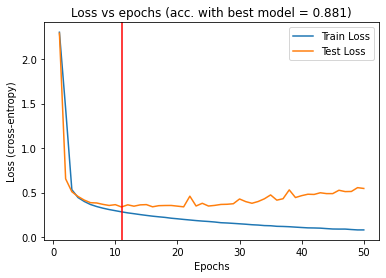

Test accuracy score of the model with the lowest test loss: 0.8815


In [ ]:
plt.plot(np.arange(len(train_loss)) + 1, train_loss, label='Train Loss')
plt.plot(np.arange(len(test_loss)) + 1, test_loss, label='Test Loss')
plt.title('Loss vs epochs (acc. with best model = %1.3f)' % test_accuracy[10])
plt.axvline(x=11, color='red')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss (cross-entropy)')
#plt.savefig('optimizer_plot.pdf', format='pdf', bbox_inches='tight')
#files.download('optimizer_plot.pdf')
plt.show()
print('Test accuracy score of the model with the lowest test loss:', test_accuracy[10])

## Task 3.6: Best MLP Architecture

To this end, our results show that an MLP with two hidden layes of size 128 and dropout of 0.9 can reach an accuracy score of 0.88, which is quite similar to the one that we have obtained with CNN. However, taking into account the results of Task 3.1, an MLP with only one hidden layer might have the potential to reach a similar accuracy score. Here, we use our previous findings and build an MLP model with only one hidden layer and try to achieve the maximum accuracy score possible.

In [ ]:
model3 = MLP(activation_fn=ReLu,
             hidden_size=[128],
             dropout=[1,0.9])

optimizer = minibatchSGD(learning_rate=0.01,
                         mini_batch_size=64,
                         max_epochs=100,
                         history_record=True,
                         history_interval=1,
                         test_data=(x_test,y_test))

y_prob = model3.fit(x_train, y_train, optimizer).predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score at the end of the run: ', evaluate_acc(y, y_pred))

Test accuracy score at the end of the run:  0.8887


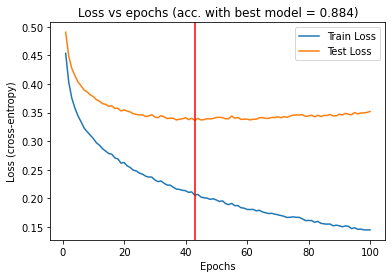

Test accuracy score of the model with the lowest test loss:  0.8836


In [ ]:
record = optimizer.history(plot=True, output=True)

y_prob = model3.restore_weights(record[-1]).predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
y = np.argmax(y_test, axis=1)

print('Test accuracy score of the model with the lowest test loss: ', evaluate_acc(y, y_pred))

The accuracy obtained with this model is comparable to that of the model with two hidden layers and CNN.

## Task 3.7: Performance reports

We have reported test and train performances of our models in each section in addition to the reports of accuracy for different hyper-parameters.